In [ ]:
import pandas as pd
from google.colab import files
import datetime
import requests
import urllib
import json
from urllib.parse import urlencode
from datetime import date
import calendar
import numpy as np
import seaborn as sns
import math as m
import matplotlib.pyplot as plt

In [ ]:
files.upload()

NameError: ignored

In [ ]:
olist_customers = pd.read_csv(yandex_csv_download('https://disk.yandex.ru/d/FUi5uSd6BfG_ig'), 
                              sep=',', error_bad_lines=False, comment='#' , encoding='cp1251')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
 olist_orders = pd.read_csv(yandex_csv_download('https://disk.yandex.ru/d/t9Li4JOfgxuUrg'), 
                              sep=',', error_bad_lines=False, comment='#' , encoding='cp1251')

Уникальные статусы заказов в таблице olist_orders_dataset:

- created —  создан
- approved —  подтверждён
- invoiced —  выставлен счёт
- processing —  в процессе сборки заказа
- shipped —  отгружен со склада
- delivered —  доставлен пользователю
- unavailable —  недоступен
- canceled —  отменён


In [ ]:
olist_items = pd.read_csv(yandex_csv_download('https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw'), 
                              sep=',', error_bad_lines=False, comment='#' , encoding='cp1251')

In [ ]:
olist_customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

- customer_id — позаказный идентификатор пользователя

- customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

- customer_zip_code_prefix —  почтовый индекс пользователя

- customer_city —  город доставки пользователя

- customer_state —  штат доставки пользователя

In [ ]:
olist_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [ ]:
olist_orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

- order_id —  уникальный идентификатор заказа (номер чека)

- customer_id —  позаказный идентификатор пользователя

- order_status —  статус заказа

- order_purchase_timestamp —  время создания заказа

- order_approved_at —  время подтверждения оплаты заказа

- order_delivered_carrier_date —  время передачи заказа в логистическую службу

- order_delivered_customer_date —  время доставки заказа

- order_estimated_delivery_date —  обещанная дата доставки

In [ ]:
olist_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [ ]:
olist_items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

- rder_id —  уникальный идентификатор заказа (номер чека)

- order_item_id —  идентификатор товара внутри одного заказа

- product_id —  ид товара (аналог штрихкода)

- seller_id — ид производителя товара

- shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

- price —  цена за единицу товара

- freight_value —  вес товара

In [ ]:
olist_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


1. Сколько у нас пользователей, которые совершили покупку только один раз?

- Объединяем таблицы olist_customers и olist_orders, по customer_id
- Статус заказа все кроме created 
- Группируем пользователей и считаем кол-во заказов 
- Отбираем пользователей с 1 заказом , считаем их

In [ ]:
ferst_data = olist_orders[['customer_id', 'order_id','order_status']].merge(olist_customers[['customer_id','customer_unique_id']], how = 'left', on = 'customer_id')

In [ ]:
ferst_data[~((ferst_data.order_status == 'created'))].groupby('customer_unique_id', as_index = False).agg({'order_id':'count'})\
.rename(columns = {'order_id':'order_amount'}).query('order_amount == 1').shape

(93096, 2)

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

- Берем таблицу olist_orders
- Вычленяем недоставленные заказы (unavailable, canceled) 
- Групперуем по статусу и месяцам 
- Счетаем сколько заказов недоставленно в каждый из месяцев 
- Берем среднее помесяцам

In [ ]:
sec_data = olist_orders.query('order_status == "unavailable" or order_status == "canceled"')[olist_orders.order_delivered_customer_date.isna()==True]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [ ]:
olist_orders.query('order_status == "unavailable" or order_status == "canceled"').shape

(1234, 8)

Есть 6 заказов у которых есть дата доставки , но статус = недействителен/отменен

In [ ]:
sec_data['order_estimated_delivery_date'] = pd.to_datetime(sec_data.order_estimated_delivery_date)
# Переводим столбец ореинтировочной даты доставки в формат даты 

In [ ]:
sec_data.groupby(['order_status', pd.Grouper(key='order_estimated_delivery_date', freq='M')]).order_id.count().to_frame()\
.reset_index()\
.groupby('order_status').agg({'order_id':'mean'})
#pd.Grouper сразу сам группирует по месяцам (freq = M), очень удобно для работы с таймлайнами 

,order_id
order_status,
canceled,23.807692
unavailable,29.000000


3. По каждому товару определить, в какой день недели товар чаще всего покупается.

- Подходят статусы все кроме created
- Мерджим таблицу заказов и таблицу товаров
- Создаемм столбец с днем недели покупки для каждого товара
- Агрегируем по каждому товару и дню недели, выбираем максимальное значение пары : товар/день недели 


In [ ]:
therd_task = olist_items.merge(olist_orders.query('order_status != "created"')[['order_id', 'order_purchase_timestamp']], how= 'left', on = 'order_id')

In [ ]:
therd_task['order_purchase_timestamp'] = pd.to_datetime(therd_task.order_purchase_timestamp)

In [ ]:
therd_task['weekday'] = therd_task['order_purchase_timestamp'].dt.day_name()

In [ ]:
therd_task.groupby(['weekday','product_id'], as_index = False).agg({'order_id':'count'})\
.pivot_table(columns = 'product_id', index = 'weekday', values = 'order_id').idxmax()\
.to_frame().rename(columns = {0: 'top_day'}).reset_index()
#idxmax находит первое максимальное вхождение по каждому столбцу(товару)и переварачивает таблицу

,product_id,top_day
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,Friday
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday
...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,Saturday
32947,fff81cc3158d2725c0655ab9ba0f712c,Monday
32948,fff9553ac224cec9d15d49f5a263411f,Friday
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday


 4.Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

1. Для каждого месяца в датасете рассчитать количество дней
2. Выделить количество недель внутри месяца, поделив кол-во дней на 7
3. Отфильтровать заказы в статусах, несоответствующих покупке
4. Приджойнить к orders уникальные идентификаторы пользователей
5. Добавить к orders колонку с месяцем покупки
6. Для каждого пользователя внутри месяца рассчитать общее количество заказов
7. К orders приджойнить количества неделя по месяцам
8. Поделить кол-во заказов по пользователям-месяцам на количество кол-во недель в месяце

In [ ]:
forth_task = olist_orders[['customer_id', 'order_id','order_status','order_purchase_timestamp']].merge(olist_customers[['customer_id','customer_unique_id']], how = 'left', on = 'customer_id')\
.query('order_status != "created"')

In [ ]:
forth_task.shape

(99436, 7)

In [ ]:
forth_task['order_purchase_timestamp'] = pd.to_datetime(forth_task.order_purchase_timestamp)

In [ ]:
forth_task['week_in_month'] = forth_task.order_purchase_timestamp.dt.daysinmonth/7

In [ ]:
forth_task['month'] = forth_task.order_purchase_timestamp.dt.strftime('%m/%Y')

In [ ]:
x = forth_task.groupby(['customer_unique_id', 'month'], as_index = False).agg({'customer_id':'count'})

In [ ]:
x = x.merge(forth_task[['week_in_month', 'month']].drop_duplicates(), on = 'month', how = 'left' )

In [ ]:
x = x.rename(columns = {'customer_id':'sails'})

In [ ]:
x['by_per_week_in_month'] = x.sails/x.week_in_month

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. 

- Для каждого пользователя выбрать первую дату доставки
- Определить когорты, путем разности даты первой покупки и даты покупки
- Выделлить целое кол-во месяце( когорты определяем месячные )
- Посчитать ретеншен по когортам
- Визуализировать хитмапом

In [ ]:
task5 = olist_orders[~olist_orders.order_status.isin(['created'])].merge(
            olist_customers[['customer_id', 'customer_unique_id']], 
            on='customer_id', 
            how='left')

In [ ]:
task5['order_purchase_timestamp'] = pd.to_datetime(task5.order_purchase_timestamp)

In [ ]:
task5 = task5.merge(task5.groupby('customer_unique_id', as_index = False).agg({'order_purchase_timestamp':'min'}).rename(columns = {'order_purchase_timestamp':'ferst_buy'}),on = 'customer_unique_id', how = 'left')

In [ ]:
task5 = task5[['order_id', 'customer_unique_id', 'order_purchase_timestamp', 'ferst_buy', 'order_status']]

In [ ]:
task5['month'] = task5.ferst_buy.dt.strftime('%m/%Y')

In [ ]:
task5['days_dist'] = (task5.order_purchase_timestamp - task5.ferst_buy).dt.days 

In [ ]:
task5['days_in_month'] = forth_task.order_purchase_timestamp.dt.daysinmonth

In [ ]:
from math import trunc

In [ ]:
task5['chort'] = (task5.days_dist / task5.days_in_month).fillna(0).apply(lambda x: m.trunc(x))
# Выделяем целое кол-во месяцев у каждой покупки, чтобы было удобнее когорты выделять 

In [ ]:
fine_5 = task5.pivot_table(index ='month', columns = 'chort', values = 'order_id', aggfunc= 'count' )

In [ ]:
all_users = fine_5[0]

In [ ]:
#Наводим красоту (сортировка)
retention = fine_5.divide(all_users, axis=0).round(3) #Формируем когорты
retention = retention.reset_index()
retention['month'] = pd.to_datetime(retention['month']).dt.date
retention = retention.sort_values('month').set_index('month')

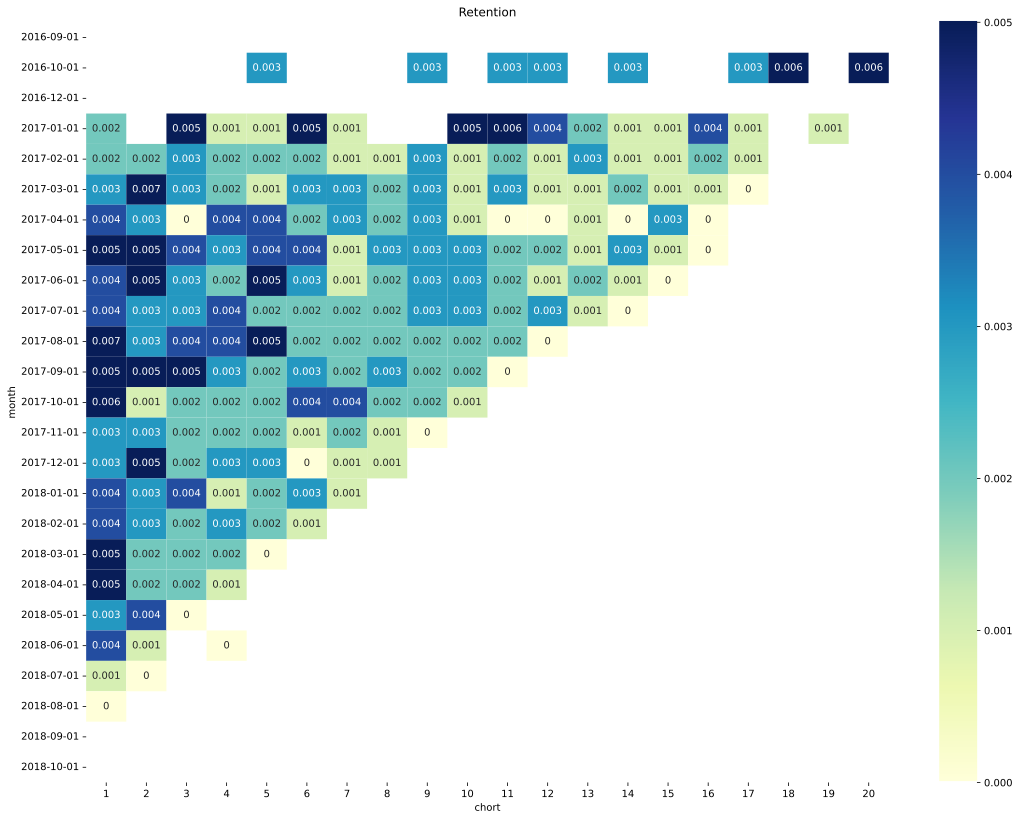

In [ ]:
plt.figure(figsize=(18,14))
plt.title('Retention')
ax = sns.heatmap(data=retention, annot=True, vmin=0.0, vmax=0.005, cmap='YlGnBu')
ax.set_yticklabels(retention.index)
fig=ax.get_figure()
plt.show()

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

In [ ]:
from numpy.lib.function_base import quantile


In [ ]:
ferst_part = olist_orders[['order_status','customer_id', 'order_id', 'order_purchase_timestamp']]\
.query('order_status != ["created"] & order_status != ["unavailable"] & order_status != ["canseled"]')\
.merge(olist_customers[['customer_unique_id', 'customer_id']], how = 'left', on = 'customer_id')

In [ ]:
fool_data = olist_items[['order_id', 'order_item_id', 'product_id', 'shipping_limit_date', 'price']].merge(ferst_part, how = 'left', on = 'order_id')

In [ ]:
olist_items.shape

(112650, 7)

In [ ]:
fool_data.shape

(112650, 9)

In [ ]:
fool_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_id                  112650 non-null  object 
 1   order_item_id             112650 non-null  int64  
 2   product_id                112650 non-null  object 
 3   shipping_limit_date       112650 non-null  object 
 4   price                     112650 non-null  float64
 5   order_status              112643 non-null  object 
 6   customer_id               112643 non-null  object 
 7   order_purchase_timestamp  112643 non-null  object 
 8   customer_unique_id        112643 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 8.6+ MB


In [ ]:
fool_data['shipping_limit_date'] = pd.to_datetime(fool_data.shipping_limit_date)

In [ ]:
fool_data['order_purchase_timestamp'] = pd.to_datetime(fool_data.shipping_limit_date)

In [ ]:
fool_data.order_id.value_counts()


8272b63d03f5f79c56e9e4120aec44ef    21
1b15974a0141d54e36626dca3fdc731a    20
ab14fdcfbe524636d65ee38360e22ce8    20
9ef13efd6949e4573a18964dd1bbe7f5    15
428a2f660dc84138d969ccd69a0ab6d5    15
                                    ..
5a0911d70c1f85d3bed0df1bf693a6dd     1
5a082b558a3798d3e36d93bfa8ca1eae     1
5a07264682e0b8fbb3f166edbbffc6e8     1
5a071192a28951b76774e5a760c8c9b7     1
fffe41c64501cc87c801fd61db3f6244     1
Name: order_id, Length: 98666, dtype: int64

In [ ]:
las_date = fool_data.order_purchase_timestamp.max()

Опредлились с Днями прошедшими с последней покупки

In [ ]:
RFM_data = fool_data.groupby('customer_unique_id').agg({'order_purchase_timestamp':'max', 'price':'sum', 'order_id':'nunique'}).reset_index()\
.rename(columns = {'order_purchase_timestamp':'last_buy', 'order_id':'orders_total', 'price' : 'total_cash'})

In [ ]:
RFM_data['days_from_last_buy'] = (las_date - RFM_data.last_buy).dt.days

In [ ]:
RFM_data.head()

,customer_unique_id,last_buy,total_cash,orders_total,days_from_last_buy
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-15 11:11:18,129.90,1,695
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-11 17:56:33,18.90,1,699
2,0000f46a3911fa3c0805444483337064,2017-03-15 21:05:03,69.00,1,1121
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-18 21:49:17,25.99,1,904
4,0004aac84e0df4da2b147fca70cf8255,2017-11-22 20:06:52,180.00,1,869


In [ ]:
RFM_data.orders_total.describe()

count    95414.00000
mean         1.03402
std          0.21124
min          1.00000
25%          1.00000
50%          1.00000
75%          1.00000
max         16.00000
Name: orders_total, dtype: float64

In [ ]:
quantils = RFM_data.quantile(q=[0.25, 0.5, 0.75])

Так как заказы распределены совсем не нормально , то для их анализа используем количественные показатели

In [ ]:
def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4
def FClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= 4:
        return 3
    elif value <= 8: 
        return 2
    else:
        return 1


def MClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1

In [ ]:
rfmSegmentation = RFM_data

In [ ]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['days_from_last_buy'].apply(RClass, args=('days_from_last_buy',quantils))

rfmSegmentation['F_Quartile'] = rfmSegmentation['orders_total'].apply(FClass, args=('orders_total',quantils))

rfmSegmentation['M_Quartile'] = rfmSegmentation['total_cash'].apply(MClass, args=('total_cash',quantils))

rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str)+ rfmSegmentation.F_Quartile.map(str)    + rfmSegmentation.M_Quartile.map(str)

In [ ]:
rfmSegmentation.groupby('RFMClass').agg({'customer_unique_id':'count', 'total_cash':'sum', 'days_from_last_buy':'mean', 'orders_total':'mean'})\
.rename(columns = {'customer_unique_id':'users_total', 'days_from_last_buy':'mean_days_from_last_buy'  })\
.reset_index()

,RFMClass,users_total,total_cash,mean_days_from_last_buy,orders_total
0,111,1,729.62,595.000000,16.000000
1,121,7,5311.51,641.000000,5.857143
2,131,514,193197.83,641.287938,2.153696
3,132,176,21249.15,640.471591,2.039773
4,133,101,7110.39,645.089109,2.039604
5,134,28,1015.10,636.285714,2.000000
6,141,5550,2032356.05,641.951532,1.000000
7,142,5809,692863.54,642.267516,1.000000
8,143,5939,395278.22,639.635124,1.000000
9,144,6034,176606.66,640.589990,1.000000
